## Environment

In [5]:
import numpy as np

from environment import RoadEnvironment
from environment_presets import small_environment_dict

### Define the environment

In [6]:
env = RoadEnvironment(**small_environment_dict)

In [7]:
def rollout(env, policy, verbose=False):

    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        actions = policy(env)
        next_state, reward, done, info = env.step(actions)

        if verbose:
            print(f' actions: {actions}, reward: {reward}')

        total_reward += reward

    return total_reward

In [ ]:
rollout(env, lambda env: [[0]*segments for segments in env.edge_segments_numbers])

Baseline: Do-nothing action

In [4]:
NUM_EPISODES = 1_000

store_do_nothing_rewards = np.zeros(NUM_EPISODES)

for episode in range(NUM_EPISODES):

    store_do_nothing_rewards[episode] = rollout(env, lambda env: [[0]*segments for segments in env.edge_segments_numbers])

print(f'Mean reward (do-nothing): {np.mean(store_do_nothing_rewards)}')

Mean reward (do-nothing): -62243.27470400004


Baseline: Failure replace action

In [5]:
NUM_EPISODES = 1_000

store_failure_replace_rewards = np.zeros(NUM_EPISODES)

for episode in range(NUM_EPISODES):

    store_failure_replace_rewards[episode] = rollout(env, lambda env: [[3 if segments == 3 else 0] for segments in env.edge_segments_numbers])

print(f'Mean reward (failure-replace): {np.mean(store_failure_replace_rewards)}')

Mean reward (failure-replace): -31016.95809600002


Baseline: Always replace

In [6]:
NUM_EPISODES = 1_000

store_always_replace_rewards = np.zeros(NUM_EPISODES)

for episode in range(NUM_EPISODES):

    store_always_replace_rewards[episode] = rollout(env, lambda env: [[3]*segment for segment in env.edge_segments_numbers])

print(f'Mean reward (always-replace): {np.mean(store_always_replace_rewards)}')

Mean reward (always-replace): -295327.99999999994


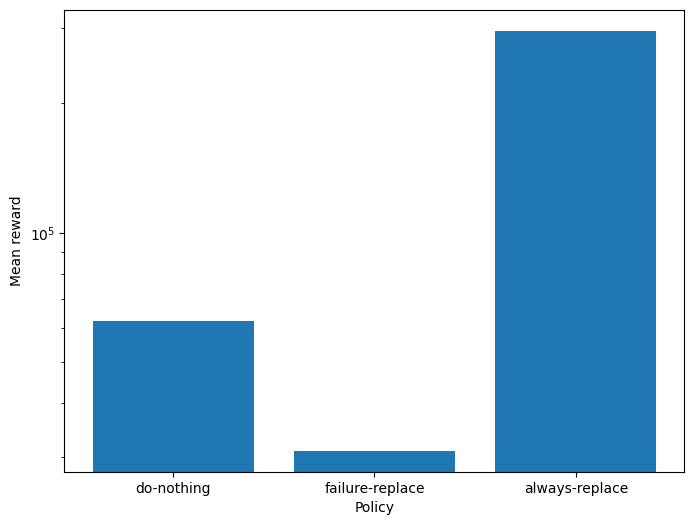

In [24]:
# plot bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
_x = ['do-nothing', 'failure-replace', 'always-replace']
_y = np.array([np.mean(store_do_nothing_rewards), np.mean(store_failure_replace_rewards), np.mean(store_always_replace_rewards)])

# add value text on top of each bar
plt.bar(_x, -1*_y, log=True)

plt.xlabel('Policy')
plt.ylabel('Mean reward')
plt.show()